In [1]:
!git clone https://github.com/AvonYangXX1/DreamWalker.git
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics
import pandas as pd

Cloning into 'DreamWalker'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 262 (delta 6), reused 48 (delta 5), pack-reused 211
Receiving objects: 100% (262/262), 886.27 MiB | 17.97 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (115/115), done.


In [2]:
marker = np.load("DreamWalker/data/processed_data/Classifier/kmer_val_0.npz")["data"].astype('float64')
lineage = np.load("DreamWalker/data/processed_data/Classifier/lineage_val_0.npz")["data"].astype('float64')

In [10]:
def create_classifier():
    path = "DreamWalker/model_weights"
    vocab_size = 3982
    length = 19
    encoder_inputs = tf.keras.layers.Input(shape=(1024,))
    x = tf.keras.layers.RepeatVector(length, name="RepeatVector")(encoder_inputs)
    x = tf.keras.layers.GRU(1024, return_sequences=True, dropout=0.2, name="GRU0")(x)
    x = tf.keras.layers.GRU(1024, return_sequences=True, dropout=0.2, name="GRU1")(x)
    x = tf.keras.layers.Dense(vocab_size, activation="softmax")(x)
    classifier = tf.keras.models.Model(encoder_inputs, x)
    classifier.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                       loss='sparse_categorical_crossentropy',metrics=["accuracy"])
    for i, layer in enumerate(classifier.layers):
        weights = np.load(f"{path}/ClassifierWeights/layer_{i}_weights.npz", allow_pickle=True)["weights"]
        layer.set_weights(weights)
        layer.trainable = False
    return classifier

def create_generator(latent_dim):
    # Load Classifier
    classifier = create_classifier()
    MarkerRepresentModule = tf.keras.models.Model(classifier.layers[0].input,
                                                  classifier.layers[-1].output,
                                                  name="ClassifierModule")
    # Load Decoder
    # autoencoder = tf.keras.models.load_model('DreamWalker/model_weights/PeptideAutoencoder.keras')
    # decoder = tf.keras.models.Model(inputs=autoencoder.layers[6].input,
    #                                 outputs=autoencoder.layers[-1].output)
    decoder = tf.keras.models.load_model('DreamWalker/model_weights/GANWeights/PeptideGenerator.keras')
    # Build Generator
    inputs = tf.keras.layers.Input(shape=(1024),name="SeqInput")
    x = MarkerRepresentModule(inputs)
    x = tf.keras.layers.Conv1D(128, 4, activation='relu', name="Conv1D")(x)
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(latent_dim, activation="tanh")(x)
    x = decoder(x)
    generator = tf.keras.models.Model(inputs, x, name="DreamWalker")
    return generator

In [4]:
def create_oracle(seq_len=40):
    inputs0 = tf.keras.layers.Input((seq_len, 43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((1024,),name="BacteriaInput")
    # Extract Peptide Features
    x0 = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x0 = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x0) # Just two layers work better
    x0 = tf.keras.layers.Flatten(name="Flatten_CNN")(x0)
    x0 = tf.keras.layers.Dense(512, activation="relu", name="CNN_Dense0")(x0)

    # Target Marker Gene Representation
    classifier = create_classifier()
    MarkerRepresentModule = tf.keras.models.Model(classifier.layers[0].input,
                                                  classifier.layers[-1].output,
                                                  name="ClassifierModule")
    x1 = MarkerRepresentModule(inputs1)
    x1 = tf.keras.layers.Conv1D(128, 4, activation='relu', name="Conv1D_GRU0")(x1)
    x1 = tf.keras.layers.Flatten(name="Flatten_GRU")(x1)
    x1 = tf.keras.layers.Dense(512, activation="relu", name="GRU_DenseLast")(x1) # mimic the previous version

    # FCN
    x = tf.keras.layers.Concatenate(axis=1, name="Concat_FCN")([x0, x1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="FCN_Dense0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="FCN_Dense1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation=tf.keras.activations.softplus, name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="Oracle")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=[tf.keras.metrics.R2Score()])
    return model

In [5]:
oracle = create_oracle()
path = "DreamWalker/model_weights/OracleWeights"
for i, layer in enumerate(oracle.layers):
    if i == 3:
        continue
    param = layer.get_weights()
    if len(param) == 0:
        continue
    weights = np.load(f"{path}/layer_{i}_weights.npz")["weights"]
    biases = np.load(f"{path}/layer_{i}_biases.npz")["biases"]
    layer.set_weights([weights, biases])

In [6]:
aa_vocal = np.load("DreamWalker/model_weights/PepTV_vocal.npy")
pep_decoder = tf.keras.layers.StringLookup(vocabulary=aa_vocal[1:], invert=True, oov_token='')
# species_vocal = np.load("AMPLify-Feedback/model_weights/SpeciesTV_vocal.npy")
# species_decoder = tf.keras.layers.StringLookup(vocabulary=species_vocal[1:], invert=True, oov_token='')

In [25]:
class Dreaming(): # This class trains the DreamWalker (exploring Oracle's dream)
    def __init__(self, latent_dim, oracle, pep_decoder):
        self.generated_onehot = None
        self.generator_loss = None
        self.gradients_of_generator = None
        self.generator_optimizer = None
        self.generator = create_generator(latent_dim)
        self.oracle = oracle
        self.pep_decoder = pep_decoder

    @tf.function
    def compute_gradient(self, marker):
        # bacteria = tf.convert_to_tensor(bacteria, np.float64)
        with tf.GradientTape() as gen_tape:
            gen_tape.watch(marker)
            self.generated_onehot = self.generator(marker, training=True)
            self.generator_loss = tf.reduce_mean(self.oracle([self.generated_onehot, marker]))
        self.gradients_of_generator = gen_tape.gradient(self.generator_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(self.gradients_of_generator, self.generator.trainable_variables))
        return self.generated_onehot

    def ExploreHallucination(self, marker, n_iter_max, batch_size):
        average_mic_train, min_mic_train, max_mic_train, median_mic_train  = [], [], [], []
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        num_batches = int(marker.shape[0] / batch_size)
        for i in range (n_iter_max):
            for j in range(0, marker.shape[0], batch_size):
                #Sequences prediction and gradient computation
                marker_batch = marker[j:j + batch_size]
                marker_batch = tf.convert_to_tensor(marker_batch, np.float64)
                generated_onehot = self.compute_gradient(marker_batch)
                generated_sequences = self.onehot2seq(generated_onehot)
                #Oracle results and statistics
                MIC = self.oracle([generated_onehot, marker_batch])
                average_mic_train += [np.mean(MIC)]
                min_mic_train += [np.min(MIC)]
                max_mic_train += [np.max(MIC)]
                median_mic_train += [np.median(MIC)]
            print(f"Iter {i+1}/{n_iter_max}; Average MIC {np.mean(MIC):.4f}")
        return average_mic_train, min_mic_train, max_mic_train, median_mic_train

    def onehot2seq(self, onehot):
        decoded_sequences = []
        chars_array = self.pep_decoder(tf.math.argmax(onehot, axis=2)).numpy().astype('str')
        decoded_sequences += ["".join(chars) for chars in chars_array]
        return decoded_sequences

In [35]:
n_iter_max = 5
batch_size = 32
latent_dim = 32
dreaming = Dreaming(latent_dim, oracle, pep_decoder)
average_mic_train, min_mic_train, max_mic_train, median_mic_train = dreaming.ExploreHallucination(marker, n_iter_max, batch_size)

Iter 1/5; Average MIC 1.8108
Iter 2/5; Average MIC 1.3303
Iter 3/5; Average MIC 1.1964
Iter 4/5; Average MIC 1.1462
Iter 5/5; Average MIC 1.2211


In [10]:
# n_iter_max = 5
# batch_size = 32
# generator = create_generator()
# generator, average_mic_train, min_mic_train, max_mic_train, median_mic_train = ExploreHallucination(generator, oracle, marker, n_iter_max, batch_size)

Iter 1/5; Average MIC 1.6025
Iter 2/5; Average MIC 1.5110
Iter 3/5; Average MIC 1.3452
Iter 4/5; Average MIC 1.1958
Iter 5/5; Average MIC 1.1030


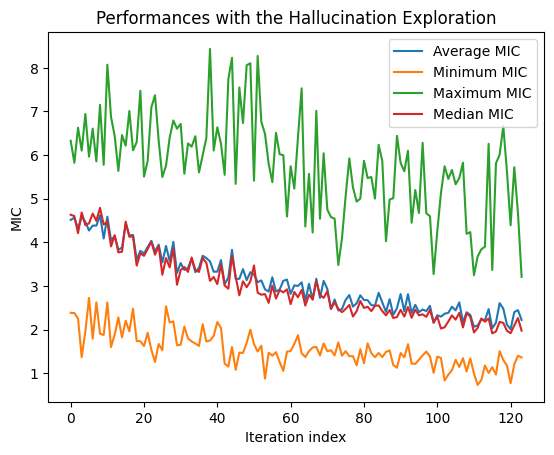

In [30]:
parameters = {"Average MIC" : average_mic_train,
              "Minimum MIC" : min_mic_train,
              "Maximum MIC" : max_mic_train,
              "Median MIC" : median_mic_train
              }
for p in list(parameters.keys()):
    plt.plot(range(len(parameters[p])), parameters[p], linestyle='-', label = p)
plt.legend(loc = "upper right")
plt.ylabel("MIC")
plt.xlabel("Iteration index")
plt.title("Performances with the Hallucination Exploration")
plt.savefig("Average_MIC.png")

In [38]:
targets = marker[0:10]
generated_sequences = dreaming.generator.predict(targets, verbose=0)
MIC = oracle.predict([generated_sequences, targets], verbose=0).flatten()
Seq = dreaming.onehot2seq(generated_sequences)
display_table = pd.DataFrame([Seq, MIC]).transpose()
print(display_table.to_string())

                       0         1
0  MRWCFWPAHPLVMRLRPWDNW   0.92007
1  RRWCFWPAHPLVMRLRPWDNW  0.849543
2  RRLVAAKRPPLVMRLRPWDNW  0.759861
3  RRLVAAKRPPLVMRLRPWDNW  0.726803
4  RRLVAAKRPPLVMRLRPWDNW  0.795491
5  RRLVAAKRPPLVMRLRRWDNW  2.084632
6  RRLVAAKRPPLVMRLRPWDNW  1.150064
7  RRLVAAKRPPLVMRLRPWDNW  1.020358
8  RRLVAAKRPPLVMRLRPWDNW   1.52603
9  RRLVAAKRPPLVMRLRPWDNW   0.60584


In [39]:
pd.DataFrame(lineage[0:10].astype('int'))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,7,11,13,12,16,17,18,20,19,24,29,39,92,85,128,3132,1925,0,0
1,7,45,47,53,52,56,57,55,58,61,3733,2798,810,0,0,0,0,0,0
2,2,3,4,94,105,173,1043,0,0,0,0,0,0,0,0,0,0,0,0
3,2,3,14,32,185,696,1697,0,0,0,0,0,0,0,0,0,0,0,0
4,2,5,470,471,3154,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,26,27,60,476,3420,98,0,0,0,0,0,0,0,0,0,0,0,0
6,2,5,41,74,75,978,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2,5,41,74,75,3392,3391,0,0,0,0,0,0,0,0,0,0,0,0
8,2,34,33,88,911,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2,26,2735,2733,2734,2732,957,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# targets = marker[0:300]
# idx = tf.argmax(bacteria[0:300], axis=1).numpy()
# generated_sequences = generator.predict(targets, verbose=0)
# MIC = oracle.predict([generated_sequences, bacteria[0:300]], verbose=0).flatten()
# Seq = onehot2seq(generated_sequences)
# display_table = pd.DataFrame([species_vocal[idx], Seq, MIC]).transpose()
# print(display_table.to_string())

In [15]:
# generator.save("drive/MyDrive/MIT687/marker2pep_generator.keras")